In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math


from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler,LabelEncoder


import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

Credits: based on https: // www.kaggle.com/crawford/principle-component-analysis-gene-expression/notebook

# PARTE 1: PCA con los datos de genes de (Golub et al.) https://www.kaggle.com/crawford/principle-component-analysis-gene-expression/

Datos usados para clasificar pacientes con acute myeloid leukemia (AML) and acute lymphoblastic leukemia (ALL).

Golub et al "Molecular Classification of Cancer: Class Discovery and Class
Prediction by Gene Expression Monitoring"

There are two datasets containing the initial (training, 38 samples) and independent (test, 34 samples) datasets used in the paper. These datasets contain measurements corresponding to ALL and AML samples from Bone Marrow and Peripheral Blood. Intensity values have been re-scaled such that overall intensities for each chip are equivalent.

# Analysis steps

1. Remove columns that contain "Call" data
2. Transpose the dataframe so that each row is a patient and each column is a gene
3. Remove gene description header and set the gene accession numbers as the column headers
4. Split into train/test sets
5. Scale values to zero mean and unit varaince
6. PCA analysis
7. To do: K-means cluster

## (1) Load data

In [2]:
testfile = 'genes/data_set_ALL_AML_independent.csv'
trainfile = 'genes/data_set_ALL_AML_train.csv'
labels = 'genes/genes.actual.csv'

X_train = pd.read_csv(trainfile)
X_test = pd.read_csv(testfile)
y = pd.read_csv(labels)

In [3]:
# 1)  Remove "call" columns from training a test
train_keepers = [col for col in X_train.columns if "call" not in col]
test_keepers = [col for col in X_test.columns if "call" not in col]

X_train = X_train[train_keepers]
X_test = X_test[test_keepers]

In [4]:
# 2) Transpose
X_train = X_train.T
X_test = X_test.T
X_train

0     \
Gene Description       AFFX-BioB-5_at (endogenous control)   
Gene Accession Number                       AFFX-BioB-5_at   
1                                                     -214   
2                                                     -139   
3                                                      -76   
4                                                     -135   
5                                                     -106   
6                                                     -138   
7                                                      -72   
8                                                     -413   
9                                                        5   
10                                                     -88   
11                                                    -165   
12                                                     -67   
13                                                     -92   
14                                                    -113   
15                                                    -107   
16                                                    -117   
17                                                    -476   
18                                                     -81   
19                                                     -44   
20                                                      17   
21                                                    -144   
22                                                    -247   
23                                                     -74   
24                                                    -120   
25                                                     -81   
26                                                    -112   
27                                                    -273   
34                                                     -20   
35                                                       7   
36                                                    -213   
37                                                     -25   
38                                                     -72   
28                                                      -4   
29                                                      15   
30                                                    -318   
31                                                     -32   
32                                                    -124   
33                                                    -135   

                                                      1     \
Gene Description       AFFX-BioB-M_at (endogenous control)   
Gene Accession Number                       AFFX-BioB-M_at   
1                                                     -153   
2                                                      -73   
3                                                      -49   
4                                                     -114   
5                                                     -125   
6                                                      -85   
7                                                     -144   
8                                                     -260   
9                                                     -127   
10                                                    -105   
11                                                    -155   
12                                                     -93   
13                                                    -119   
14                                                    -147   
15                                                     -72   
16                                                    -219   
17                                                    -213   
18                                                    -150   
19                                                     -51   
20                                                    -229   
21                                                    -199   
22                     

In [5]:
# 3) Clean up the column names for training data
X_train.columns = X_train.iloc[1]
X_train = X_train.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

# Clean up the column names for training data
X_test.columns = X_test.iloc[1]
X_test = X_test.drop(["Gene Description", "Gene Accession Number"]).apply(pd.to_numeric)

X_train.head()

Gene Accession Number  AFFX-BioB-5_at  AFFX-BioB-M_at  AFFX-BioB-3_at  \
1                                -214            -153             -58   
2                                -139             -73              -1   
3                                 -76             -49            -307   
4                                -135            -114             265   
5                                -106            -125             -76   

Gene Accession Number  AFFX-BioC-5_at  AFFX-BioC-3_at  AFFX-BioDn-5_at  \
1                                  88            -295             -558   
2                                 283            -264             -400   
3                                 309            -376             -650   
4                                  12            -419             -585   
5                                 168            -230             -284   

Gene Accession Number  AFFX-BioDn-3_at  AFFX-CreX-5_at  AFFX-CreX-3_at  \
1                                  199            -176             252   
2                                 -330            -168             101   
3                                   33            -367             206   
4                                  158            -253              49   
5                                    4            -122              70   

Gene Accession Number  AFFX-BioB-5_st  ...  U48730_at  U58516_at  U73738_at  \
1                                 206  ...        185        511       -125   
2                                  74  ...        169        837        -36   
3                                -215  ...        315       1199         33   
4                                  31  ...        240        835        218   
5                                 252  ...        156        649         57   

Gene Accession Number  X06956_at  X16699_at  X83863_at  Z17240_at  \
1                            389        -37        793        329   
2                            442        -17        782        295   
3                            168         52       1138        777   
4                            174       -110        627        170   
5                            504        -26        250        314   

Gene Accession Number  L49218_f_at  M71243_f_at  Z78285_f_at  
1                               36          191          -37  
2                               11           76          -14  
3                               41          228          -41  
4                              -50          126          -91  
5                               14           56          -25  

[5 rows x 7129 columns]

In [6]:
# 4) Split into train and test 
X_train = X_train.reset_index(drop=True)
y_train = y[y.patient <= 38].reset_index(drop=True)

# Subet the rest for testing
X_test = X_test.reset_index(drop=True)
y_test = y[y.patient > 38].reset_index(drop=True)


## Exploratory data analysis

Realiza un análisis exploratorio de los datos (correlaciones entre sí y con las clases, distribuciones,...). Usa las técnicas y gráficos que te parezcan más representativos.

En primer lugar conviene notar que nuestro conjunto de datos tiene un total de 7129 características, lo que convierte el problema en un problema de alta dimensión. 

In [7]:
X_train.shape

(38, 7129)

En segundo lugar vamos a observar si existen missing values en el conjunto de datos. 

In [8]:
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [9]:
draw_missing_data_table(X_train)

Total  Percent
Gene Accession Number                
AFFX-BioB-5_at             0      0.0
X87241_at                  0      0.0
X89067_at                  0      0.0
X89066_at                  0      0.0
X89059_at                  0      0.0
...                      ...      ...
M93718_at                  0      0.0
M93650_at                  0      0.0
M93426_at                  0      0.0
M93425_at                  0      0.0
Z78285_f_at                0      0.0

[7129 rows x 2 columns]

In [10]:
(draw_missing_data_table(X_train)==0).all()

Total      True
Percent    True
dtype: bool

Como podemos observar, los datos están completos. 

A continuación codificamos cada clase de modo que {1: 'ALL', 2: 'AML'} y ilustramos un histograma de cada clase para las primeras 100 características.

In [11]:
y = y_train['cancer'].values
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1
label_dict = {1: 'ALL', 2: 'AML'}

In [12]:
def plot_histograms(X, features, i):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))
    n_class = 2
    for ax,cnt in zip(axes.ravel(), range(4)):  

        # set bin sizes
        min_b = math.floor(np.min(X[:,cnt]))
        max_b = math.ceil(np.max(X[:,cnt]))
        bins = np.linspace(min_b, max_b, 25)

        # plottling the histograms
        for lab,col in zip(range(1,n_class+1), ('blue', 'red')):
            ax.hist(X[y==lab, cnt],
                       color=col,
                       label='class %s' %label_dict[lab],
                       bins=bins,
                       alpha=0.5,)
        ylims = ax.get_ylim()

        # plot annotation
        leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
        leg.get_frame().set_alpha(0.5)
        ax.set_ylim([0, max(ylims)+2])
        ax.set_xlabel(features[cnt])
        ax.set_title('Cancer histogram #%s' %str(i+cnt+1))

        # hide axis ticks
        ax.tick_params(axis="both", which="both", bottom="off", top="off",  
                labelbottom="on", left="off", right="off", labelleft="on")

        # remove axis spines
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)    

    axes[0][0].set_ylabel('count')
    axes[1][0].set_ylabel('count')

    fig.tight_layout()       

    plt.show()

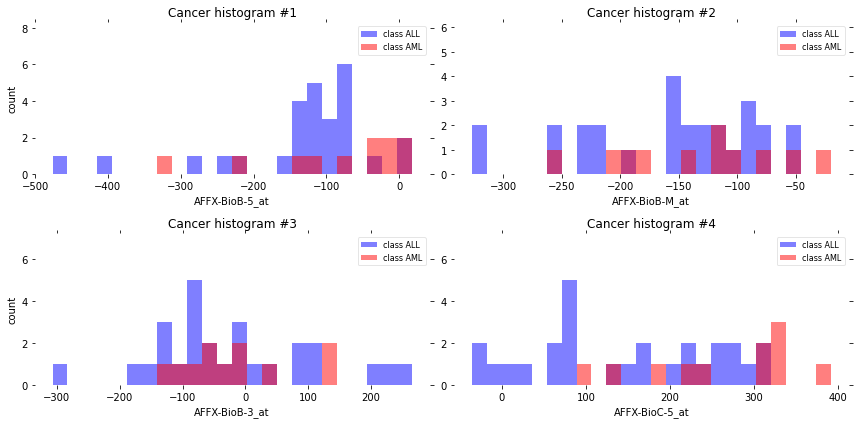

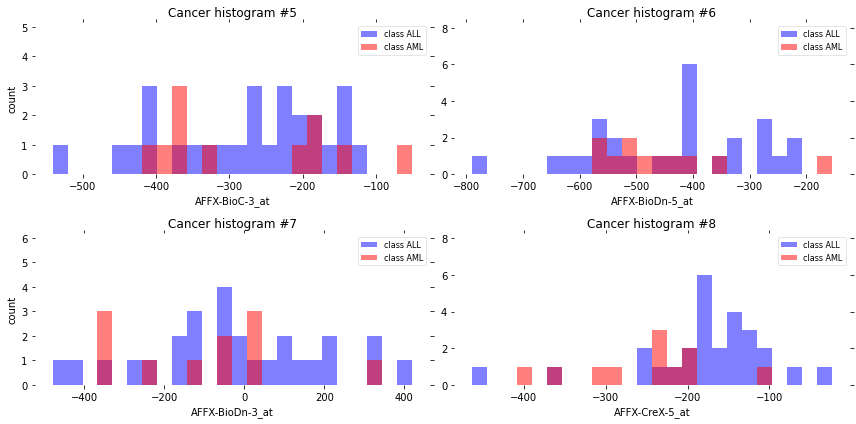

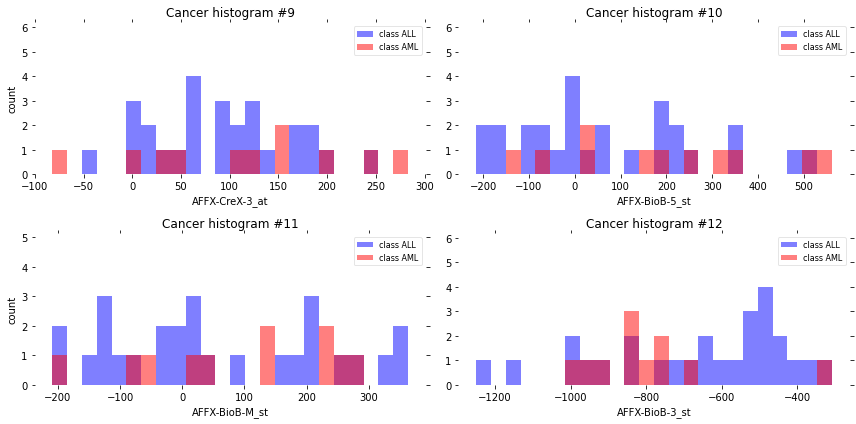

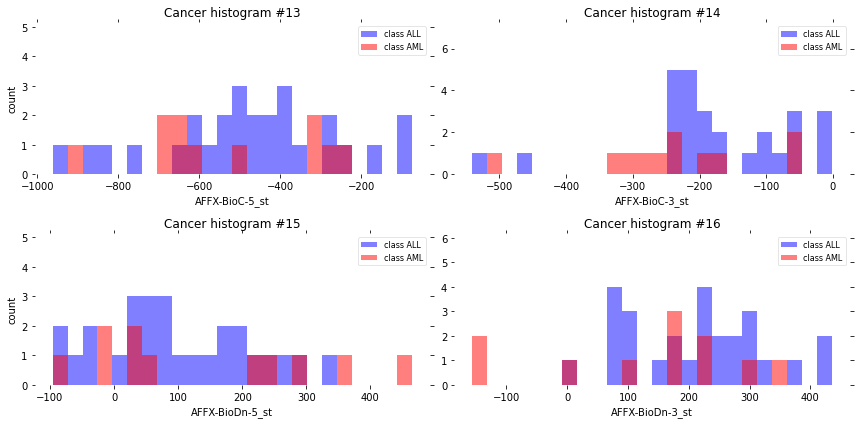

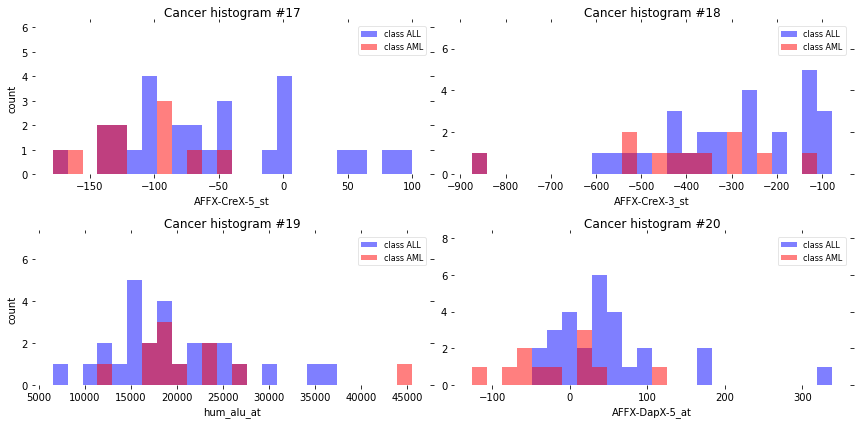

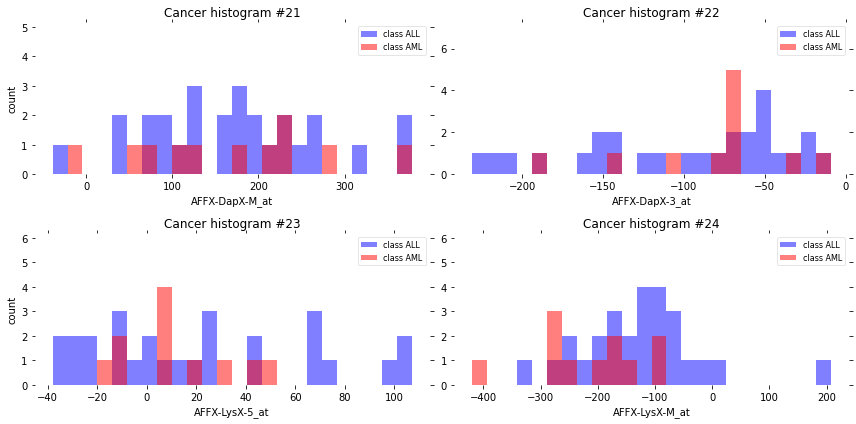

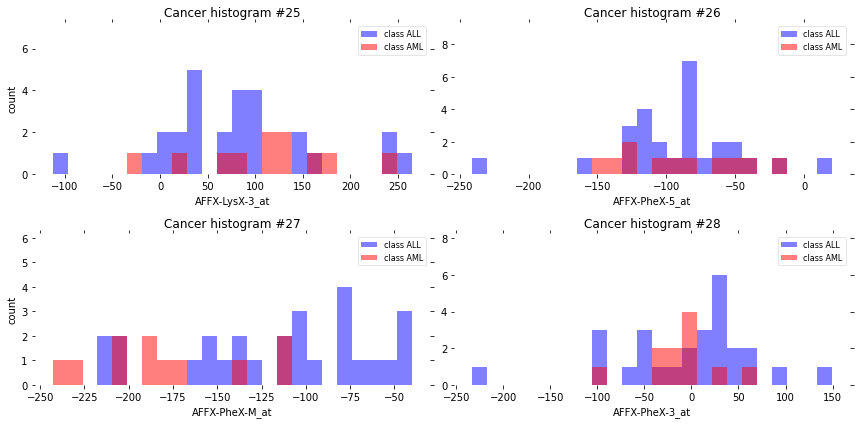

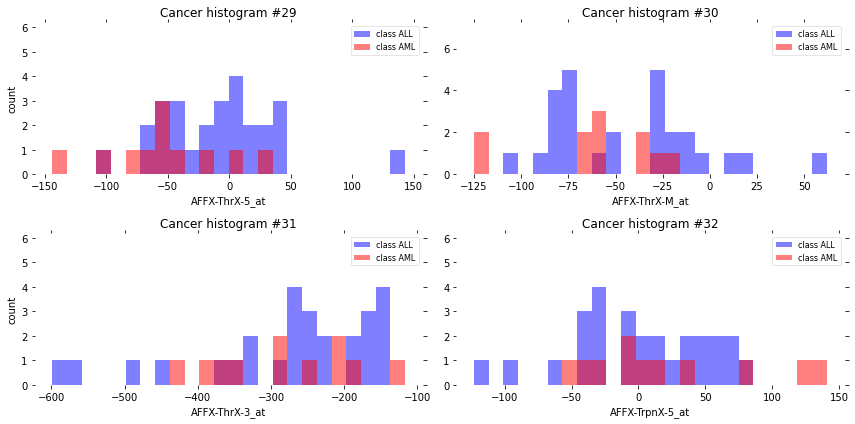

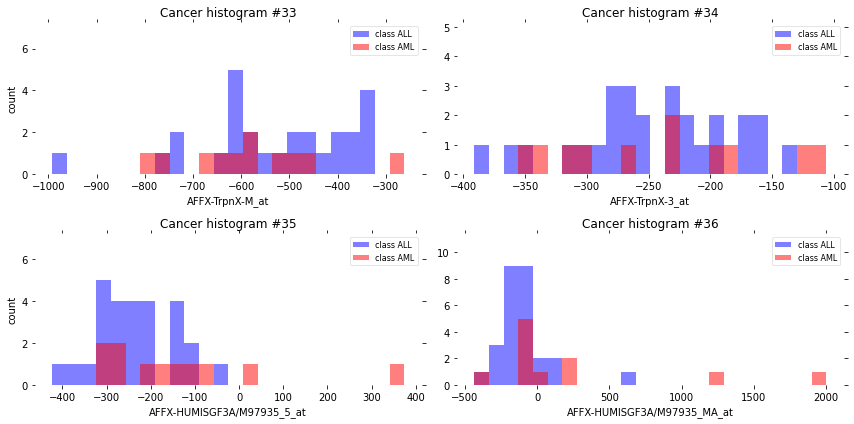

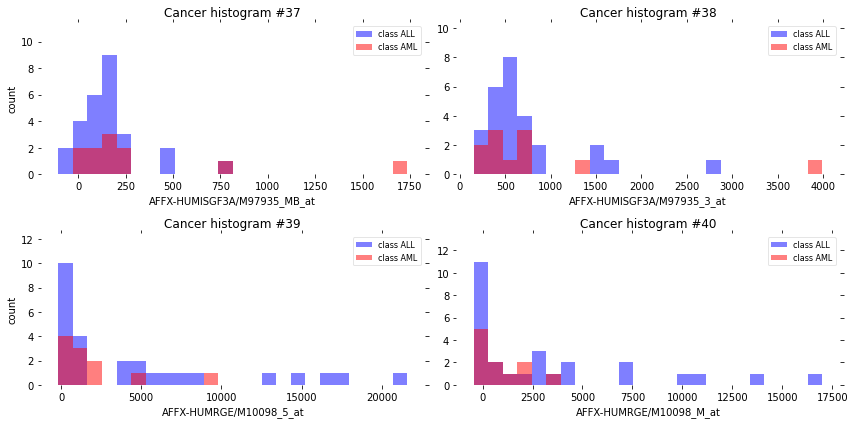

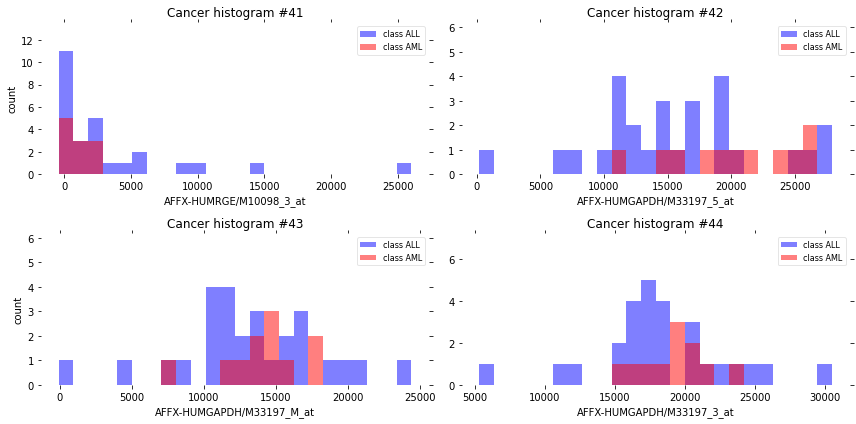

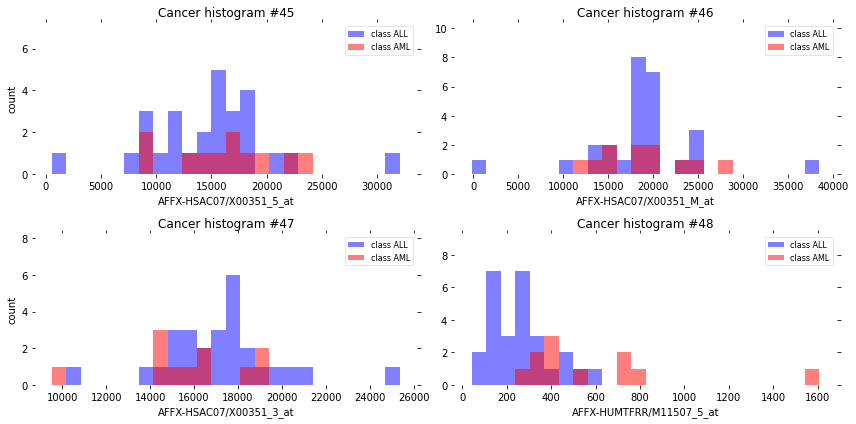

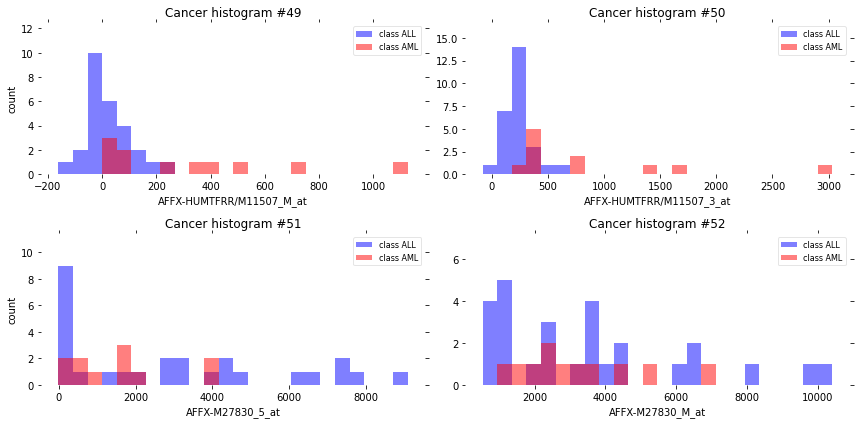

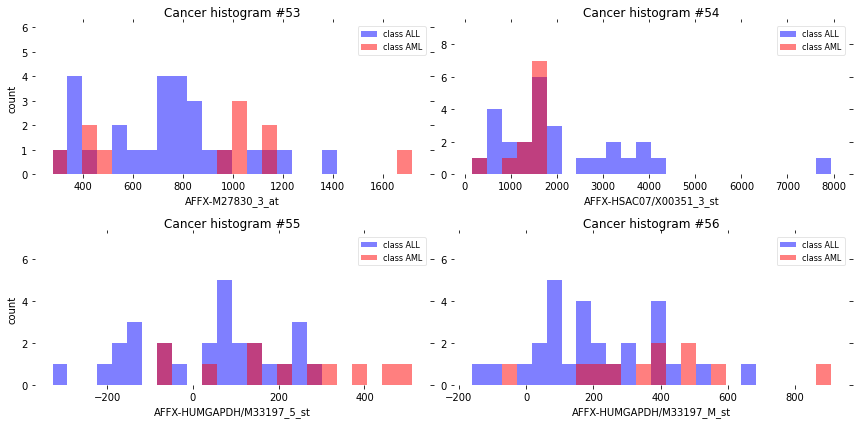

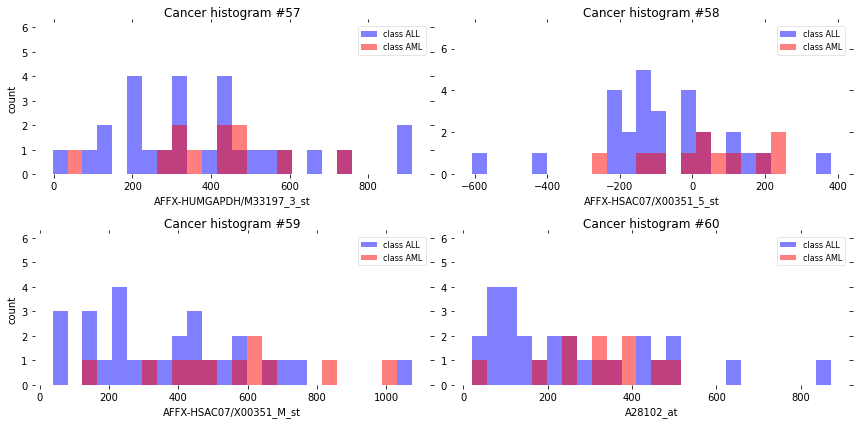

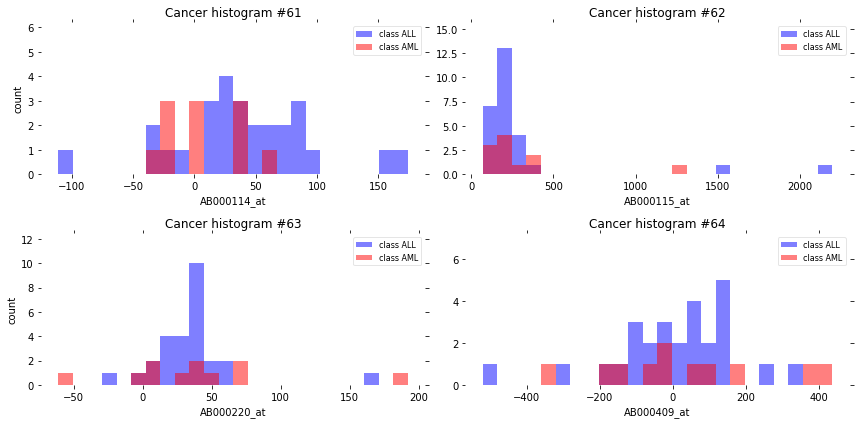

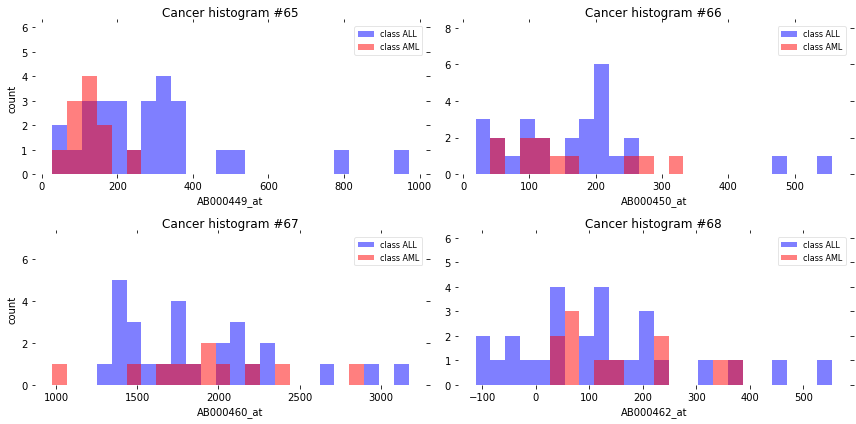

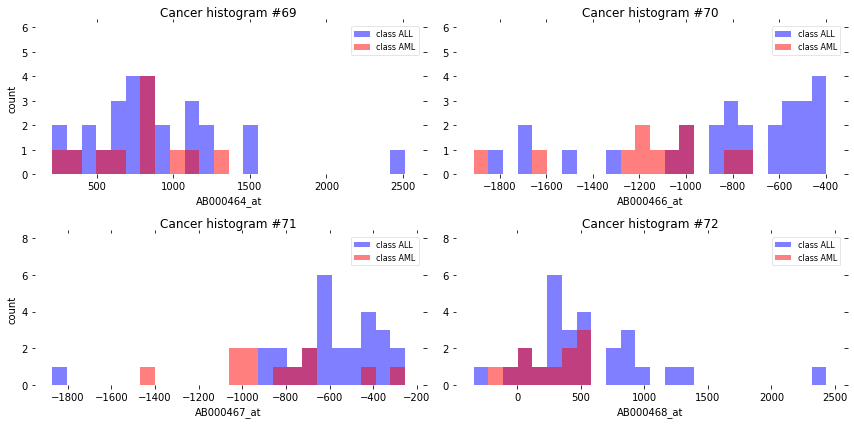

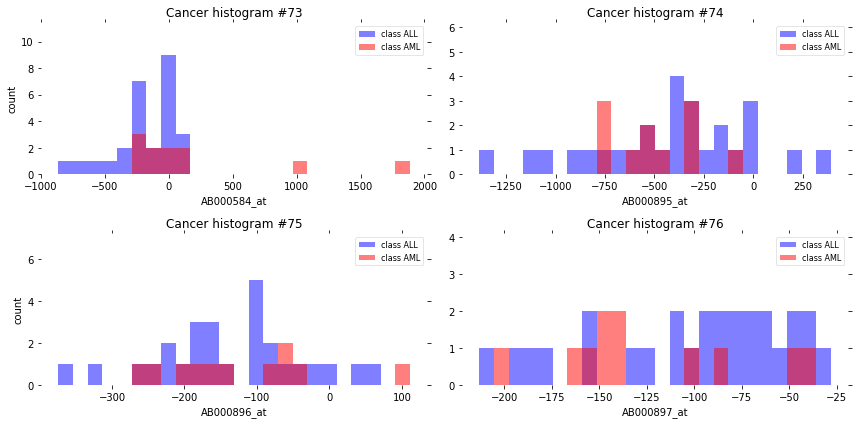

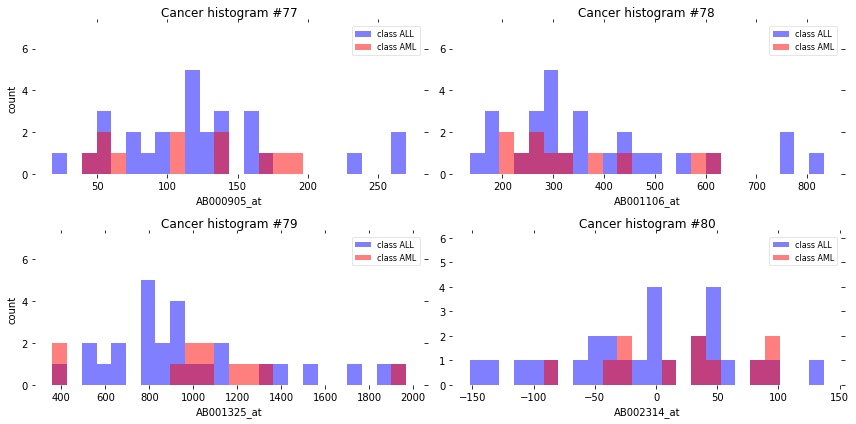

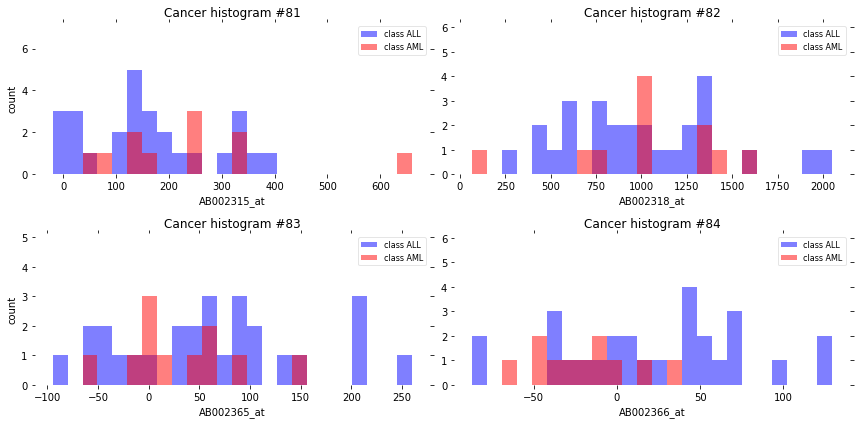

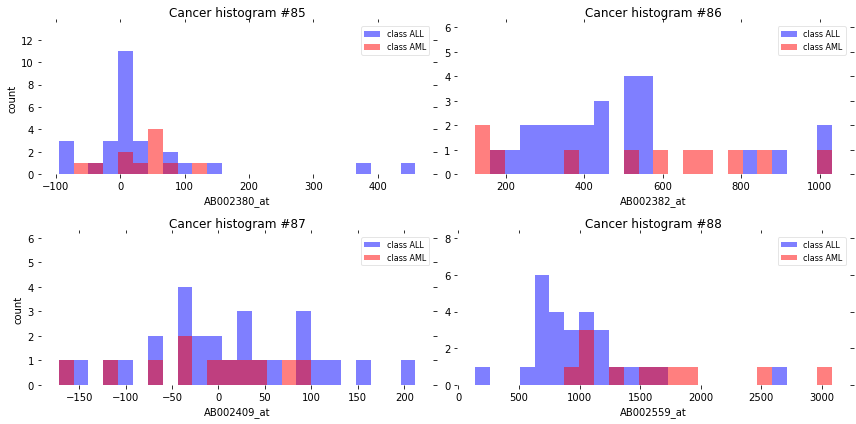

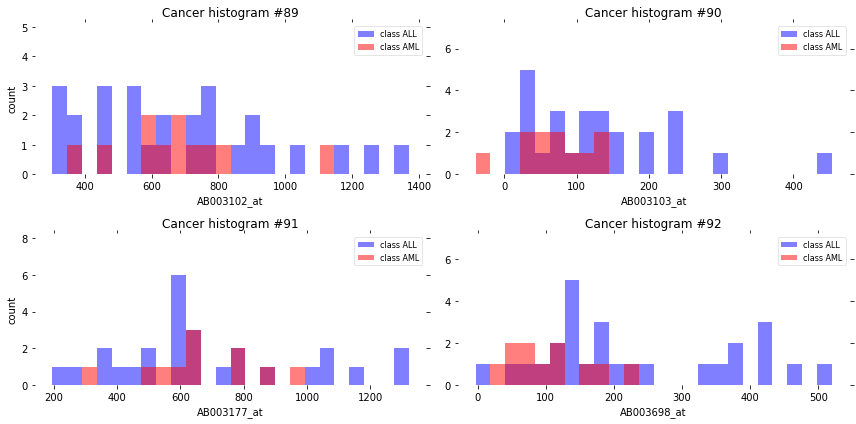

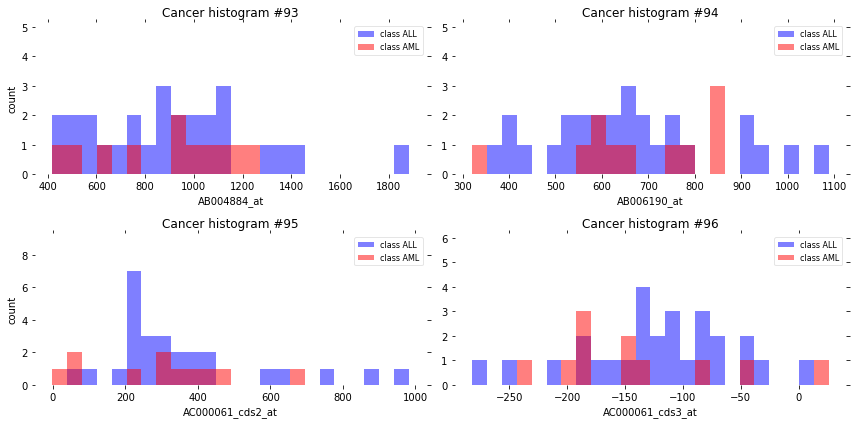

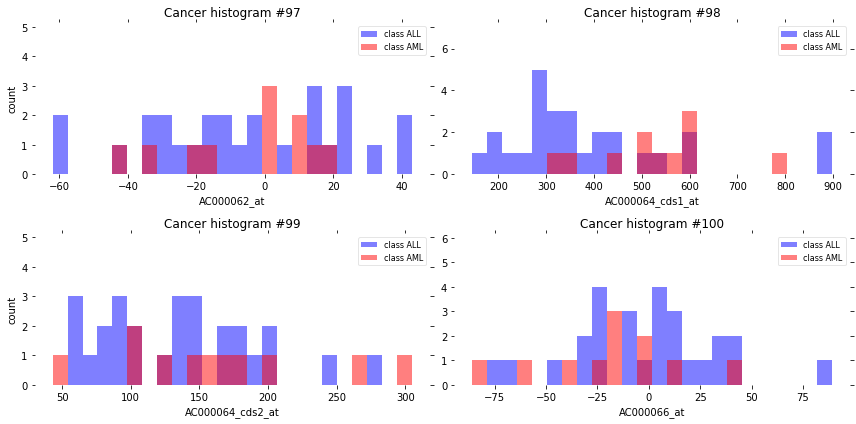

In [13]:
for i in range(0,100,4):
    features = X_train.columns[i:i+4]
    X = X_train[features].values
    plot_histograms(X, features, i)

Observamos que en cada histograma las clases se solapan y no presentan una distribución conocida. También puede observarse la presencia de outliers en cada clase para cada característica. 

## (2) Principle Component Analysis

The analysis reveals that 21 principle components are needed to account for 80% of the variance. PC 1-3 add up to  about ~33% and the rest is a slow burn where each component after PC8 contributes between 1-2% of the variance up until PC38 which is essentially zero. 1% is a decent amonut of variance and so the number of important PCs is up for interpretation. 

In [14]:
# 5) Scale data 
# (1) YOUR CODE HERE: Use the StandardScaler (separately for train and test sets)
scaler = StandardScaler().fit(X_train)
X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.fit_transform(X_test)

In [15]:
# 6) PCA Analysis and projection
components = 21
# YOUR CODE HERE: 
# (2) Use PCA with this number of components on train set, with Y the result of the procedure
pca = PCA(n_components=components)
Y = pca.fit(X_train_scl)

# (3) Retrieve the explained variance ratio, and compute its accumulative sum
# save those values in variables var_exp and cum_var_exp
var_exp = Y.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

In [16]:
print(var_exp)
print(cum_var_exp)

[0.14987793 0.11977811 0.06600566 0.0488492  0.0463241  0.03721949
 0.03490831 0.03289512 0.02985195 0.02644395 0.02508489 0.02355515
 0.02202755 0.02084964 0.01938288 0.01892547 0.01843203 0.01703705
 0.0169899  0.01641344 0.01524567]
[0.14987793 0.26965604 0.3356617  0.3845109  0.430835   0.46805449
 0.5029628  0.53585792 0.56570987 0.59215382 0.6172387  0.64079385
 0.6628214  0.68367104 0.70305392 0.7219794  0.74041143 0.75744848
 0.77443838 0.79085183 0.80609749]


Con 21 componentes se consigue un 80% de la varianza explicada.

**Pregunta (1)**: ¿Qué pauta puede observarse en los valores de var_exp? ¿Cuál es la interpretación relativa de esos valores?

var_exp es el vector que contiene la varianza total explicada por cada componente principal con respecto al conjunto. Vemos que cada vez la varianza explicada por cada componente principal es menor ya que las primeras componentes son las que maximizan la variabilidad de los datos. 

Sea $\Sigma$ la matriz de covarianzas de los datos $X$ que queremos proyectar, la dirección de los componentes principales son los autovectores normalizados de $\Sigma$ correspondientes a los autovalores ordenador de mayor a menor. De manera que los autovalores $\lambda_1>\lambda_2>...$ de $\Sigma$ coinciden con la varianza de las proyecciones. Por tanto, las últimas componentes son aquellas cuyas proyecciones tienen menor varianza y eliminarlas no supone una gran pérdida de información. 

In [17]:
# Plot the explained variance using var_exp and cum_var_exp
x = ["PC%s" %i for i in range(1,components)]
trace1 = go.Bar(
    x=x,
    y=list(var_exp),
    name="Explained Variance")

trace2 = go.Scatter(
    x=x,
    y=cum_var_exp,
    name="Cumulative Variance")

layout = go.Layout(
    title='Explained variance',
    xaxis=dict(title='Principle Components', tickmode='linear'))

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)

## (3) Projection of first three components
The first three components only explain 33% of the variance but we'll go ahead plot the projection to get a visual of it. 

In [18]:
# Project first three components
Y_train_pca = pca.fit_transform(X_train_scl)

traces = []
for name in ['ALL', 'AML']:
    trace = go.Scatter3d(
        x=Y_train_pca[y_train.cancer == name, 0],
        y=Y_train_pca[y_train.cancer == name, 1],
        z=Y_train_pca[y_train.cancer == name, 2],
        mode='markers',
        name=name,
        marker=go.Marker(size=10, line=go.Line(width=1), opacity=1))

    traces.append(trace)

layout = go.Layout(
    xaxis=dict(title='PC1'),
    yaxis=dict(title='PC2'),
    title="Projection of First Three Principle Components"
)

data = traces
fig = go.Figure(data=data, layout=layout)
offline.iplot(fig)


/home/maria/main/main/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


/home/maria/main/main/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:434: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.




**Pregunta(2)**: Modificando la perspectiva de la figura con el ratón, ¿qué observas en cuanto a la separabilidad de las clases? Adjunta una imagen que apoye tus conclusiones.


En la imagen adjuntada, vemos que la separación de las clases es prácticamente lineal.
![pca_pregunta2](pca.png)

# Parte 2: Linear Discriminant Analysis

In [19]:
# LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
sklearn_lda = LDA(n_components=1)

# Y_train_pca = pca.fit_transform(X_train_scl)

X_lda_sklearn = sklearn_lda.fit_transform(X_train_scl, y['cancer'][:38])


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

NameError: name 'X_lda_sklearn' is not defined

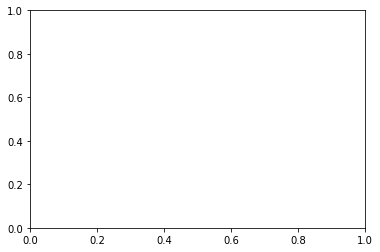

In [20]:

from matplotlib import pyplot as plt 

def plot_step_lda():

    ax = plt.subplot(111)
    for label, marker, color in zip(
            range(1, 4), ('^', 's', 'o'), ('blue', 'red', 'green')):

        plt.scatter(x=X_lda_sklearn[:, 0].real[y == label],
                    y=X_lda_sklearn[:, 1].real[y == label],
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label]
                    )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",
                    labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)

    plt.grid()
    plt.tight_layout
    plt.show()

def plot_scikit_lda(X, title):

   ax = plt.subplot(111)
   for label, marker, color in zip(
           range(1, 4), ('^', 's', 'o'), ('blue', 'red', 'green')):

       plt.scatter(x=X[:, 0][y == label],
                   y=X[:, 1][y == label] * -1,  # flip the figure
                   marker=marker,
                   color=color,
                   alpha=0.5,
                   label=label_dict[label])

   plt.xlabel('LD1')
   plt.ylabel('LD2')

   leg = plt.legend(loc='upper right', fancybox=True)
   leg.get_frame().set_alpha(0.5)
   plt.title(title)

   # hide axis ticks
   plt.tick_params(axis='both', which='both', bottom='off', top='off',
                   labelbottom='on', left='off', right='off', labelleft='on')

   # remove axis spines
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.spines['bottom'].set_visible(False)
   ax.spines['left'].set_visible(False)

   plt.grid()
   plt.tight_layout
   plt.show()


plot_step_lda()
plot_scikit_lda(X_lda_sklearn, title='Default LDA via scikit-learn')
